In [62]:
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [76]:
# Database connection parameters
db_params = {
    'dbname': 'movie_db', 
    'user': 'postgres', 
    'password': os.environ['POSTGRES_PASSWORD'], 
    'host': '49.13.1.33',
    'port': '5333'
}

# Connection
conn = psycopg2.connect(**db_params)

# Helper function to query the database
def query_db(sql_query, conn):
    return pd.read_sql_query(sql_query, conn)

# Queries
movie_lengths_stats = query_db("SELECT MIN(runtime) as min_runtime, MAX(runtime) as max_runtime, AVG(runtime) as avg_runtime FROM Movies", conn)


movies_per_genre = query_db("SELECT Genres.name, COUNT(MovieGenres.genre_id) as num_movies FROM MovieGenres JOIN Genres ON MovieGenres.genre_id = Genres.id GROUP BY Genres.name", conn)


movie_stats = query_db("""
SELECT
    AVG(runtime) as avg_runtime,
    AVG(budget) as avg_budget,
    AVG(revenue) as avg_revenue,
    MIN(release_date) as earliest_release,
    MAX(release_date) as latest_release
FROM Movies
""", conn)


genre_stats = query_db("""
SELECT 
    Genres.name, 
    COUNT(*) as num_movies,
    AVG(Movies.runtime) as avg_runtime
FROM MovieGenres
JOIN Genres ON MovieGenres.genre_id = Genres.id
JOIN Movies ON MovieGenres.movie_id = Movies.id
GROUP BY Genres.name
""", conn)


production_stats = query_db("""
SELECT 
    ProductionCompanies.name, 
    COUNT(*) as num_movies,
    AVG(Movies.budget) as avg_budget,
    AVG(Movies.revenue) as avg_revenue
FROM MovieProductionCompanies
JOIN ProductionCompanies ON MovieProductionCompanies.production_company_id = ProductionCompanies.id
JOIN Movies ON MovieProductionCompanies.movie_id = Movies.id
GROUP BY ProductionCompanies.name
""", conn)


language_stats = query_db("""
SELECT 
    original_language, 
    COUNT(*) as num_movies
FROM Movies
GROUP BY original_language
""", conn)


popularity_stats = query_db("""
SELECT
    AVG(popularity) as avg_popularity,
    AVG(vote_average) as avg_vote,
    COUNT(*) as num_movies
FROM movies_popularity
""", conn)


print("General Movie Statistics:\n", movie_stats, movie_stats.describe())
print("\nGenre Analysis:\n", genre_stats, genre_stats.describe())
print("\nProduction Analysis:\n", production_stats, production_stats.describe())
print("\nLanguage Analysis:\n", language_stats, language_stats.describe())
print("\nPopularity and Ratings Analysis:\n", popularity_stats, popularity_stats.describe())
print("Movie Lengths Statistics:\n", movie_lengths_stats, movie_lengths_stats.describe())
print("\nMovies per Genre:\n",movies_per_genre, movies_per_genre.describe())

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2795991324.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


General Movie Statistics:
        avg_runtime    avg_budget   avg_revenue
count     1.000000  1.000000e+00  1.000000e+00
mean     80.059103  9.271218e+06  2.781976e+07
std            NaN           NaN           NaN
min      80.059103  9.271218e+06  2.781976e+07
25%      80.059103  9.271218e+06  2.781976e+07
50%      80.059103  9.271218e+06  2.781976e+07
75%      80.059103  9.271218e+06  2.781976e+07
max      80.059103  9.271218e+06  2.781976e+07

Genre Analysis:
         num_movies  avg_runtime
count    19.000000    19.000000
mean   2277.105263    89.945153
std    1874.674280    14.448662
min     267.000000    54.490296
25%    1068.000000    81.518175
50%    1813.000000    95.172827
75%    2499.000000    99.456665
max    7927.000000   110.552318

Production Analysis:
          num_movies    avg_budget   avg_revenue
count  16900.000000  1.690000e+04  1.690000e+04
mean       2.709704  8.861444e+06  2.116978e+07
std       11.134327  2.146124e+07  6.472367e+07
min        1.000000  0.000000

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2795991324.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


How many films don't have a imdb_id------3832
How many films don't have a overview------463
How many films don't have a tagline------3074
How many films don't have a release_date------913
How many films don't have a backdrop_path------6330
How many films don't have a poster_path------1825
How many films don't have a homepage------3488
How many films don't have a budget------ 15380
How many films don't have a runtime------ 2288


<Axes: >

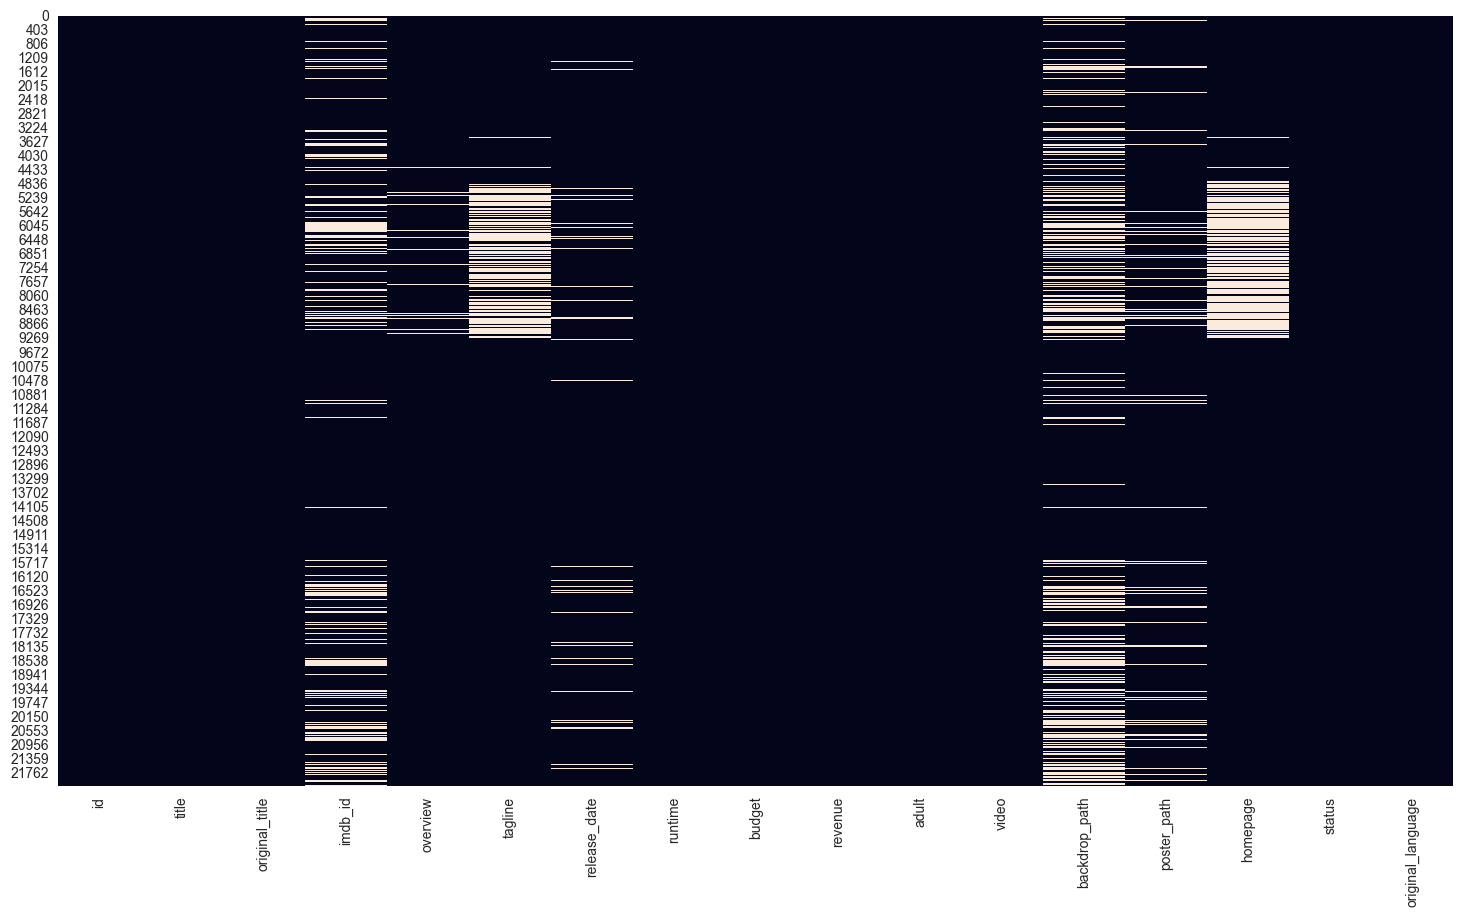

In [83]:
movies = query_db("""
SELECT * FROM Movies
""", conn)



# Print all rows that have at least one null value

null_columns = [feature for feature in movies.columns if movies[feature].isnull().sum() > 0]
for col in null_columns:
    print(f"How many films don't have a {col}" + "------" + str(movies[col].isnull().sum()))
    

# How many films don't have a budget
print("How many films don't have a budget------",len(movies[movies['budget'] == 0]))

# How many films don't have a runtime
print("How many films don't have a runtime------",len(movies[movies['runtime'] == 0]))

plt.figure(figsize = (18,10))
sns.heatmap(movies.isnull() , cbar = False)

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


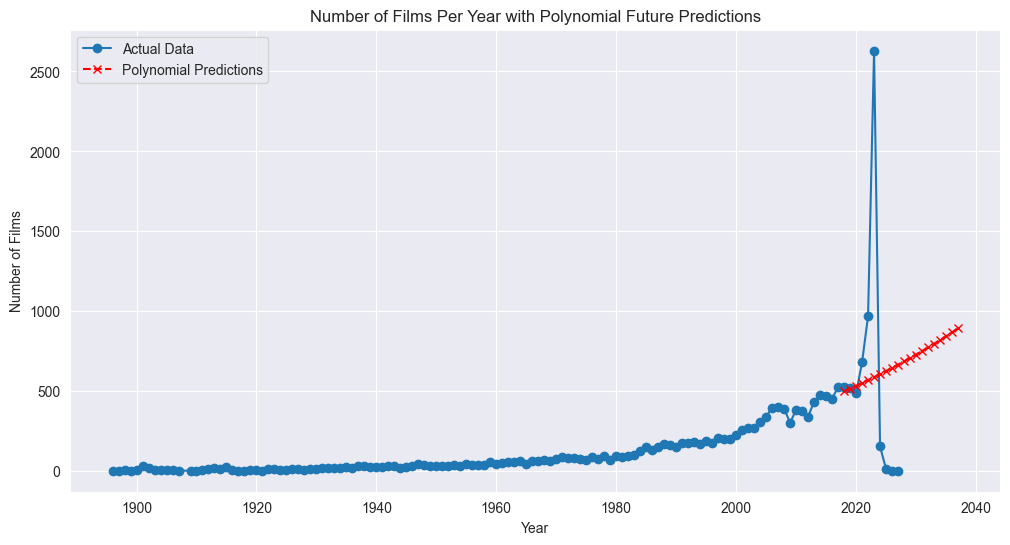

In [66]:
number_of_films_per_year =query_db( """
SELECT 
    EXTRACT(YEAR FROM release_date) AS release_year, 
    COUNT(*) AS num_films 
FROM Movies 
WHERE release_date IS NOT NULL 
GROUP BY release_year 
ORDER BY release_year
""", conn)


number_of_years_to_predict = 20
number_of_years_to_go_back = 10

# Training data
X = number_of_films_per_year['release_year'].values[:-number_of_years_to_go_back].reshape(-1, 1)  # Feature (release year)
y = number_of_films_per_year['num_films'].values[:-number_of_years_to_go_back]  # Target (number of films)

# Polynomial degree
degree = 3

# Polynomial features
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

# Create and fit the model
poly_model = LinearRegression()
poly_model.fit(X_poly, y)


future_years = np.array(range(int(X.max()) + 1, int(X.max()) + number_of_years_to_predict + 1)).reshape(-1, 1)

# Prepare future data
future_years_poly = poly.transform(future_years)

# Predict polynomial 
future_predictions_poly = poly_model.predict(future_years_poly)

plt.figure(figsize=(12, 6))
plt.plot(number_of_films_per_year['release_year'], number_of_films_per_year['num_films'], marker='o', label='Actual Data')
plt.plot(future_years.flatten(), future_predictions_poly, marker='x', linestyle='--', color='red', label='Polynomial Predictions')
plt.title('Number of Films Per Year with Polynomial Future Predictions')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


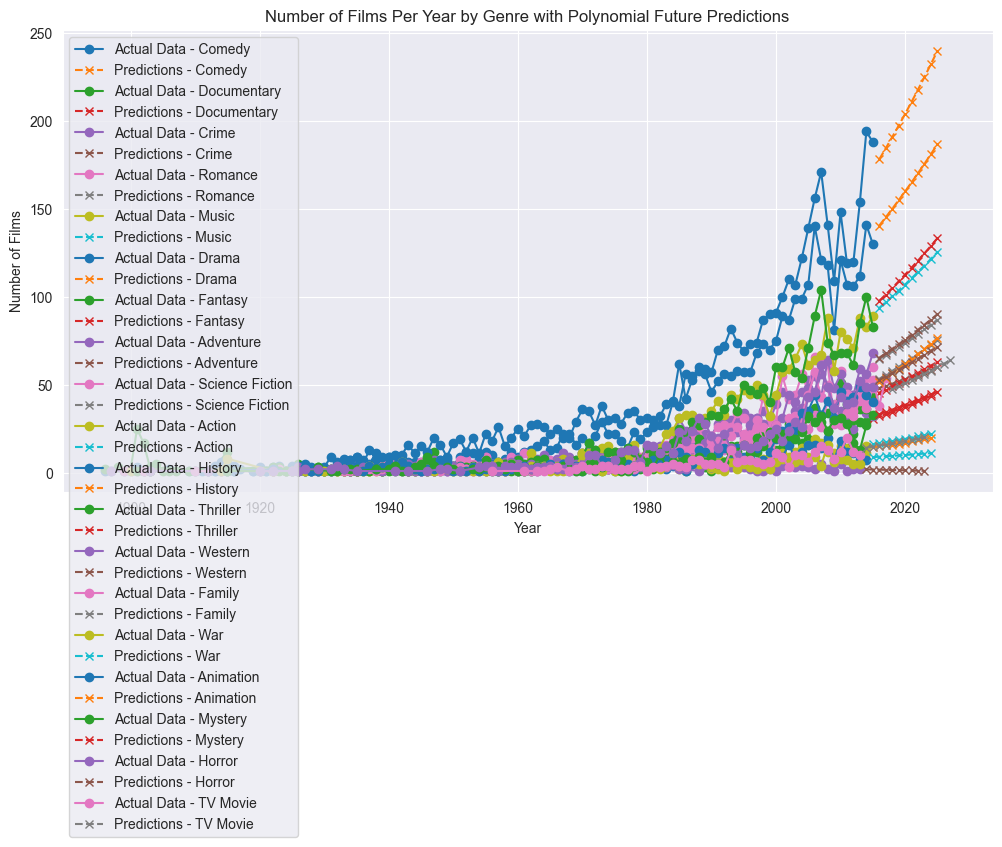

In [75]:
number_of_films_per_genre_per_year =query_db( """
SELECT 
    EXTRACT(YEAR FROM Movies.release_date) AS release_year, 
    Genres.name AS genre,
    COUNT(Movies.id) AS num_films
FROM Movies 
JOIN MovieGenres ON Movies.id = MovieGenres.movie_id
JOIN Genres ON MovieGenres.genre_id = Genres.id
WHERE Movies.release_date IS NOT NULL
GROUP BY release_year, Genres.name
ORDER BY release_year, Genres.name;
""", conn)

number_of_years_to_predict = 10
number_of_years_to_go_back = 10

genres = number_of_films_per_genre_per_year['genre'].unique()

poly = PolynomialFeatures(degree=degree)

plt.figure(figsize=(12, 6))

for genre in genres:
    # Filter data for genre
    genre_data = number_of_films_per_genre_per_year[number_of_films_per_genre_per_year['genre'] == genre]
    
    # Training data
    X = genre_data['release_year'].values[:-number_of_years_to_go_back].reshape(-1, 1)
    y = genre_data['num_films'].values[:-number_of_years_to_go_back]
    
    # Future years
    future_years = np.array(range(int(X.max()) + 1, int(X.max()) + number_of_years_to_predict + 1)).reshape(-1, 1)
    
    # Polynomial 
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    
    # Predict 
    future_years_poly = poly.transform(future_years)
    future_predictions = poly_model.predict(future_years_poly)
    
    # Plot
    plt.plot(X.flatten(), y, marker='o', label=f'Actual Data - {genre}')
    plt.plot(future_years.flatten(), future_predictions, marker='x', linestyle='--', label=f'Predictions - {genre}')

plt.title('Number of Films Per Year by Genre with Polynomial Future Predictions')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


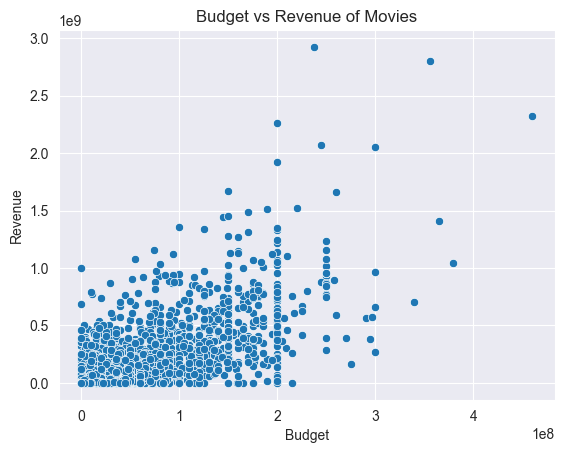

In [6]:
budget_vs_revenue =query_db( """
SELECT budget, revenue
FROM Movies
WHERE budget IS NOT NULL AND revenue IS NOT NULL;
""", conn)

sns.scatterplot(x='budget', y='revenue', data=budget_vs_revenue)
plt.title('Budget vs Revenue of Movies')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

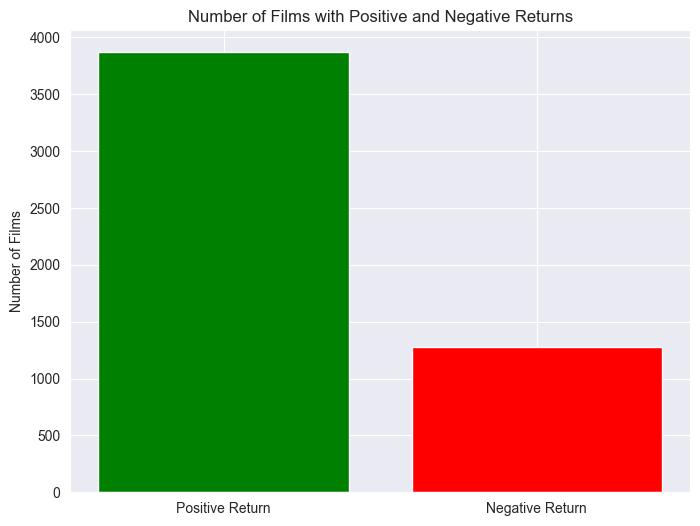

In [84]:
# Calculate the return
budget_vs_revenue['return'] = budget_vs_revenue['revenue'] - budget_vs_revenue['budget']

# Filter
filtered_df = budget_vs_revenue[(budget_vs_revenue['budget'] > 0) & (budget_vs_revenue['revenue'] > 0)]

# Positive and negative returns
positive_return_count = (filtered_df['return'] > 0).sum()
negative_return_count = (filtered_df['return'] < 0).sum()

# Data for plotting
return_counts = [positive_return_count, negative_return_count]
categories = ['Positive Return', 'Negative Return']

plt.figure(figsize=(8, 6))
plt.bar(categories, return_counts, color=['green', 'red'])
plt.title('Number of Films with Positive and Negative Returns')
plt.ylabel('Number of Films')
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


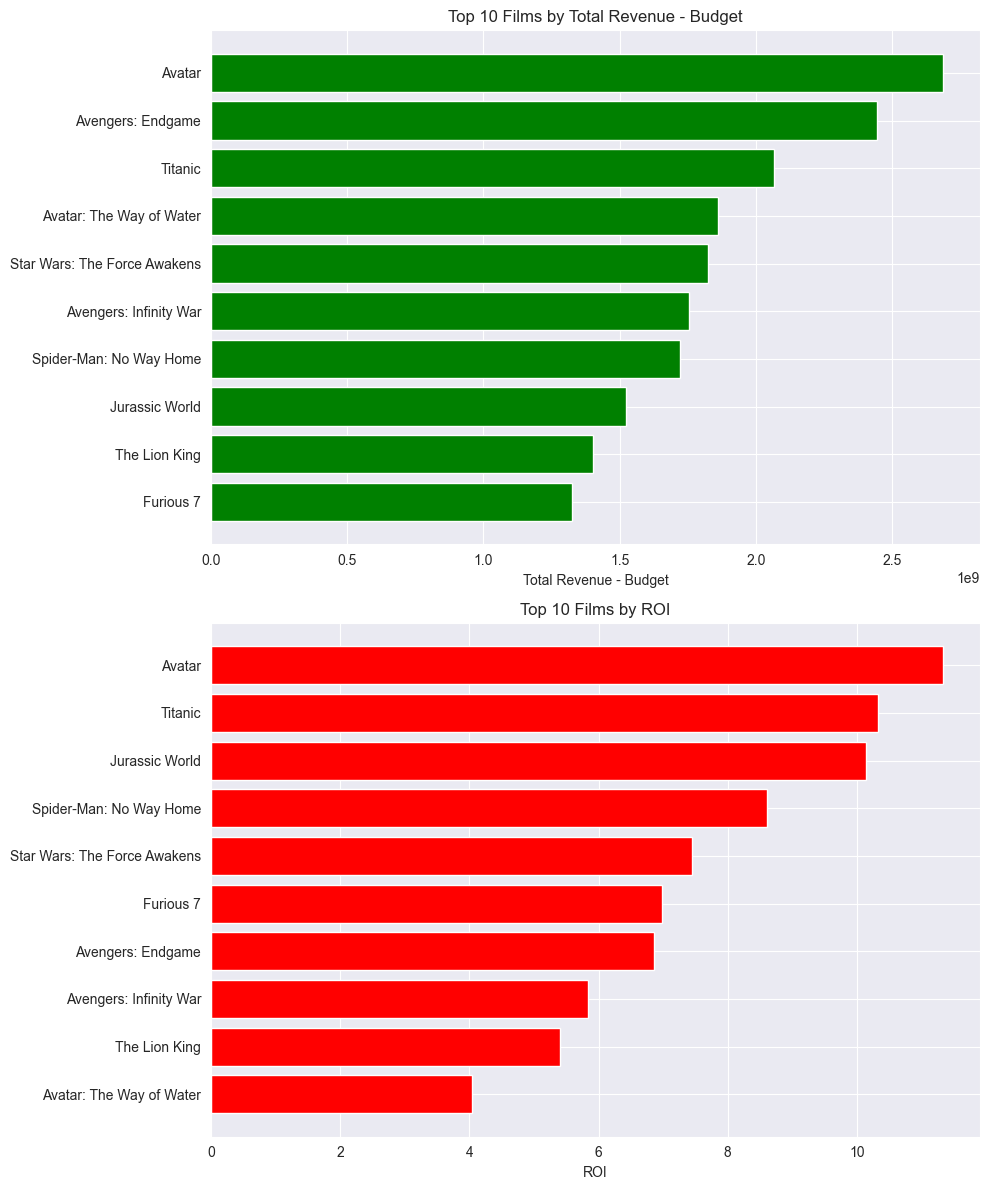

In [35]:
top_10_revenue_to_budget =query_db( """
SELECT title, (revenue - budget) as total, (revenue - budget) / budget as roi, budget, revenue
FROM Movies
WHERE budget > 0 AND revenue > 0
ORDER BY total DESC
LIMIT 10;
""", conn)

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot for Total Revenue - Budget
ax1.barh(top_10_revenue_to_budget['title'], top_10_revenue_to_budget['total'], color='green')
ax1.set_xlabel('Total Revenue - Budget')
ax1.set_title('Top 10 Films by Total Revenue - Budget')
ax1.invert_yaxis()

# Plot for ROI
top_10_revenue_to_budget = top_10_revenue_to_budget.sort_values(by='roi', ascending=False)
ax2.barh(top_10_revenue_to_budget['title'], top_10_revenue_to_budget['roi'], color='red')
ax2.set_xlabel('ROI')
ax2.set_title('Top 10 Films by ROI')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


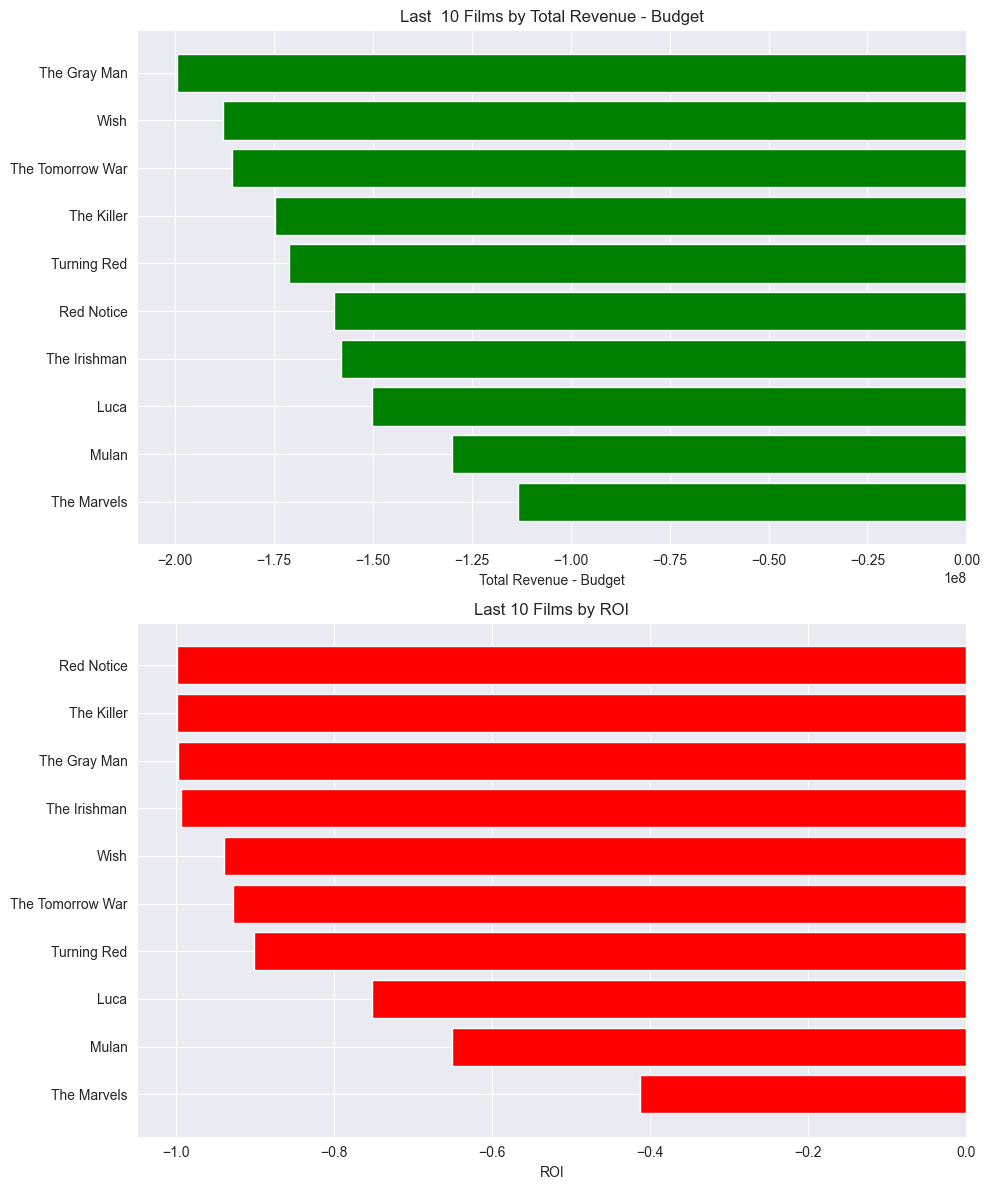

In [37]:
last_10_revenue_to_budget =query_db( """
SELECT title, (revenue - budget) as total, (revenue - budget) / budget as roi, budget, revenue
FROM Movies
WHERE budget > 0 AND revenue > 0
ORDER BY total
LIMIT 10;
""", conn)

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot for Total Revenue - Budget
ax1.barh(last_10_revenue_to_budget['title'], last_10_revenue_to_budget['total'], color='green')
ax1.set_xlabel('Total Revenue - Budget')
ax1.set_title('Last  10 Films by Total Revenue - Budget')
ax1.invert_yaxis()

# Plot for ROI
last_10_revenue_to_budget = last_10_revenue_to_budget.sort_values(by='roi', ascending=True)
ax2.barh(last_10_revenue_to_budget['title'], last_10_revenue_to_budget['roi'], color='red')
ax2.set_xlabel('ROI')
ax2.set_title('Last 10 Films by ROI')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2795991324.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


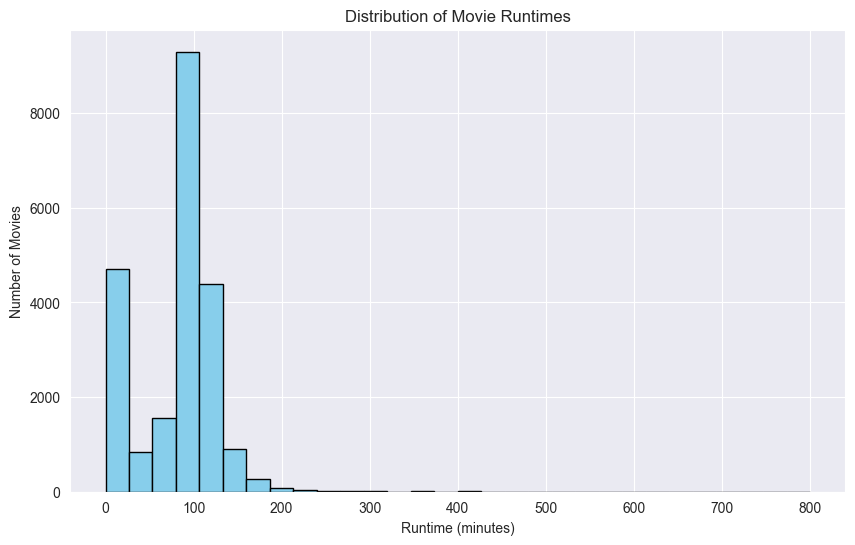

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\23256065.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_revenue_by_group = runtime_groups.groupby('runtime_group')['revenue'].mean()


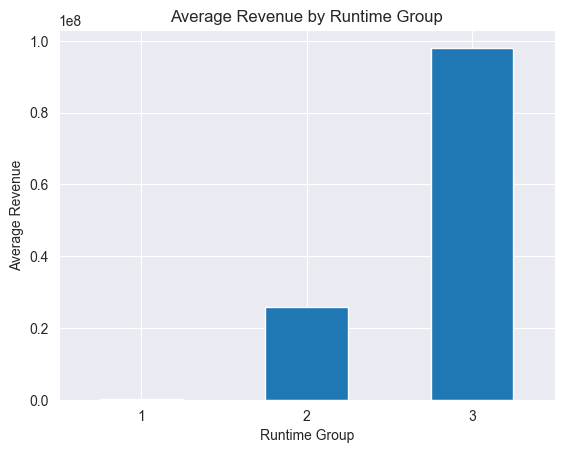

In [88]:
runtime_distribution =query_db( """
SELECT runtime, revenue
FROM Movies
WHERE runtime IS NOT NULL AND revenue IS NOT NULL;
""", conn)

# Distribution of runtime
plt.figure(figsize=(10, 6))
plt.hist(runtime_distribution['runtime'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.show()

# Build Groups
runtime_groups = runtime_distribution.copy()
runtime_groups['runtime_group'] = pd.cut(runtime_groups['runtime'], bins=[0, 60, 120, float('inf')], labels=[1, 2, 3])

# Average revenue for each group
average_revenue_by_group = runtime_groups.groupby('runtime_group')['revenue'].mean()

average_revenue_by_group.plot.bar()
plt.title('Average Revenue by Runtime Group')
plt.xlabel('Runtime Group')
plt.ylabel('Average Revenue')
plt.xticks(rotation=0)  
plt.show()


C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


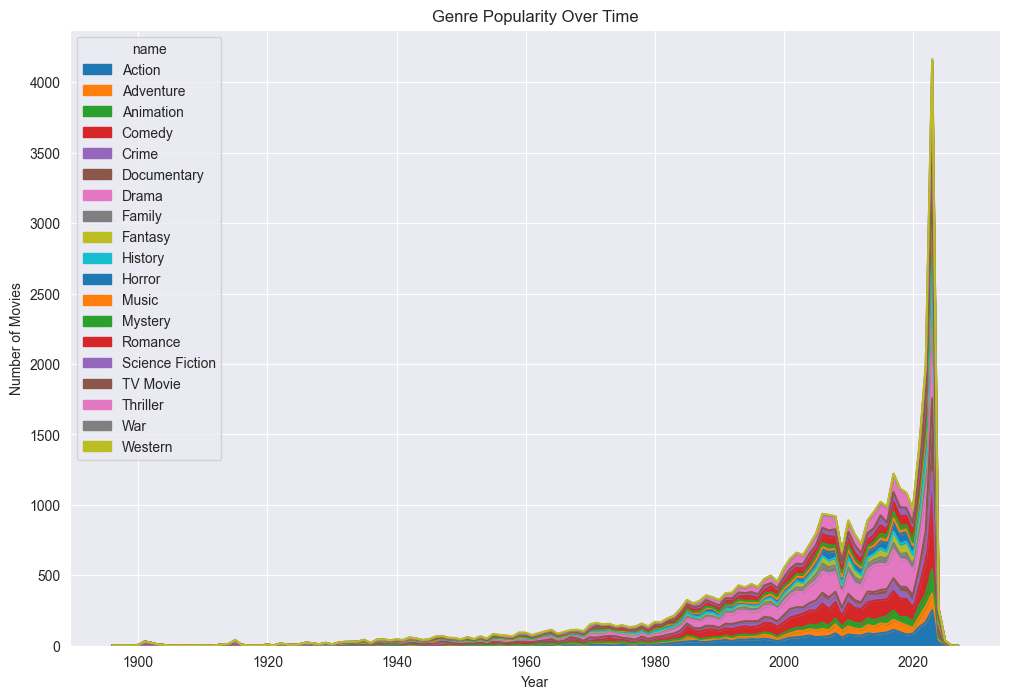

In [8]:
genre_popularity_over_time =query_db( """
SELECT EXTRACT(YEAR FROM Movies.release_date) as year, Genres.name, COUNT(*) as num_movies
FROM Movies
JOIN MovieGenres ON Movies.id = MovieGenres.movie_id
JOIN Genres ON MovieGenres.genre_id = Genres.id
GROUP BY year, Genres.name
ORDER BY year, Genres.name;
""", conn)

genre_pivot = genre_popularity_over_time.pivot(index='year', columns='name', values='num_movies').fillna(0)
genre_pivot.plot.area(figsize=(12, 8))
plt.title('Genre Popularity Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


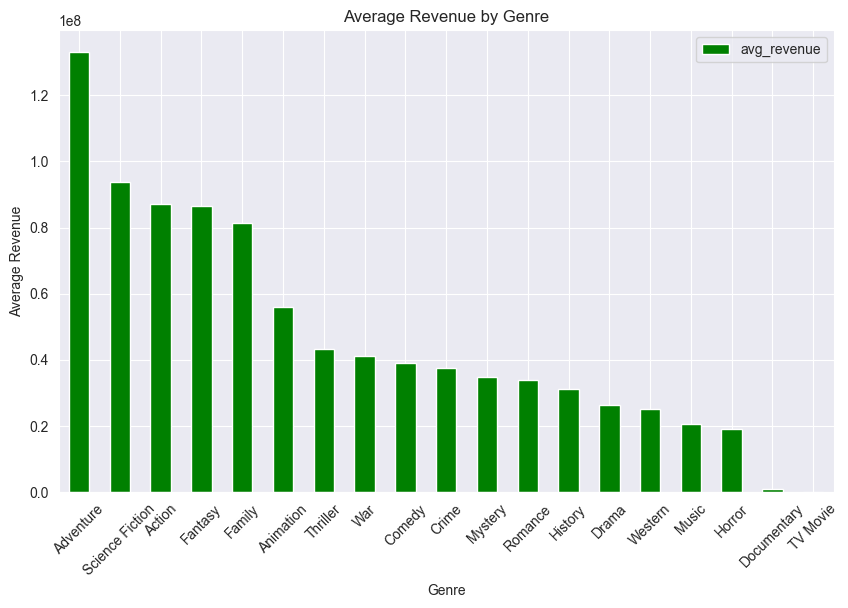

In [9]:
top_grossing_genres =query_db( """
SELECT Genres.name, AVG(Movies.revenue) as avg_revenue
FROM Movies
JOIN MovieGenres ON Movies.id = MovieGenres.movie_id
JOIN Genres ON MovieGenres.genre_id = Genres.id
GROUP BY Genres.name
ORDER BY avg_revenue DESC;
""", conn)

top_grossing_genres.plot(kind='bar', x='name', y='avg_revenue', color='green', figsize=(10, 6))
plt.title('Average Revenue by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


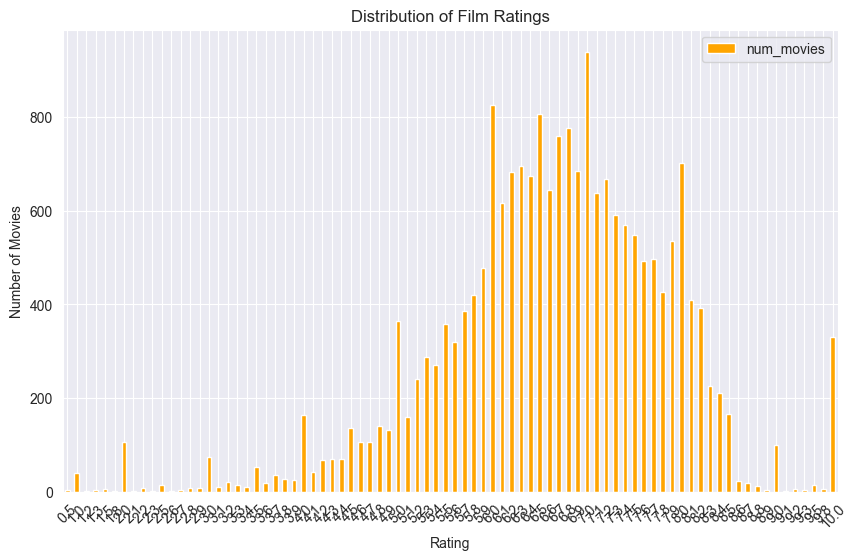

In [10]:
film_rating_analysis = query_db("""
SELECT movies_popularity.vote_average as rating, COUNT(*) as num_movies
FROM Movies
JOIN movies_popularity ON Movies.id = movies_popularity.movie_id
WHERE movies_popularity.vote_average > 0
GROUP BY movies_popularity.vote_average
ORDER BY movies_popularity.vote_average;
""", conn)

film_rating_analysis.plot(kind='bar', x='rating', y='num_movies', color='orange', figsize=(10, 6))
plt.title('Distribution of Film Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


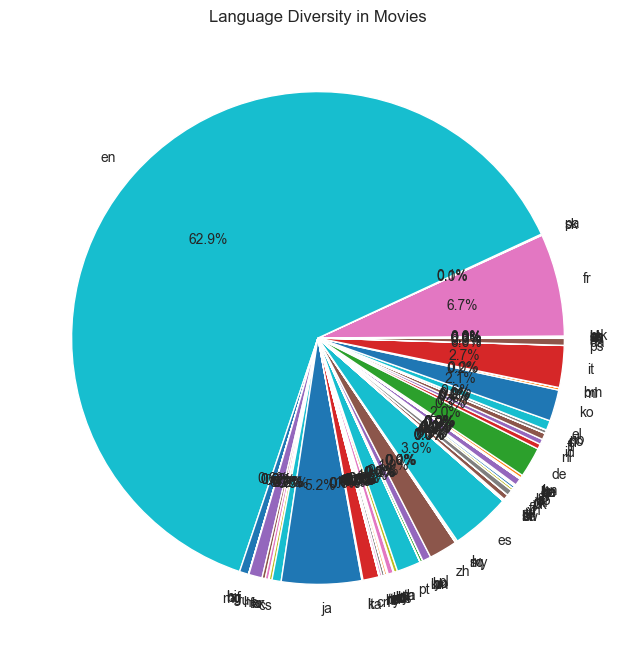

In [11]:
language_diversity_in_movies =query_db( """
SELECT original_language, COUNT(*) as num_movies
FROM Movies
GROUP BY original_language;
""", conn)

language_diversity_in_movies.set_index('original_language')['num_movies'].plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Language Diversity in Movies')
plt.ylabel('')
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


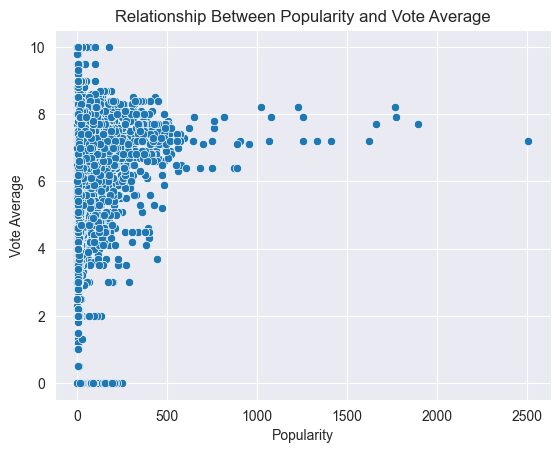

In [12]:
popularity_and_vote_analysis =query_db( """
SELECT popularity, vote_average
FROM movies_popularity
WHERE popularity IS NOT NULL AND vote_average IS NOT NULL;
""", conn)
sns.scatterplot(x='popularity', y='vote_average', data=popularity_and_vote_analysis)
plt.title('Relationship Between Popularity and Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


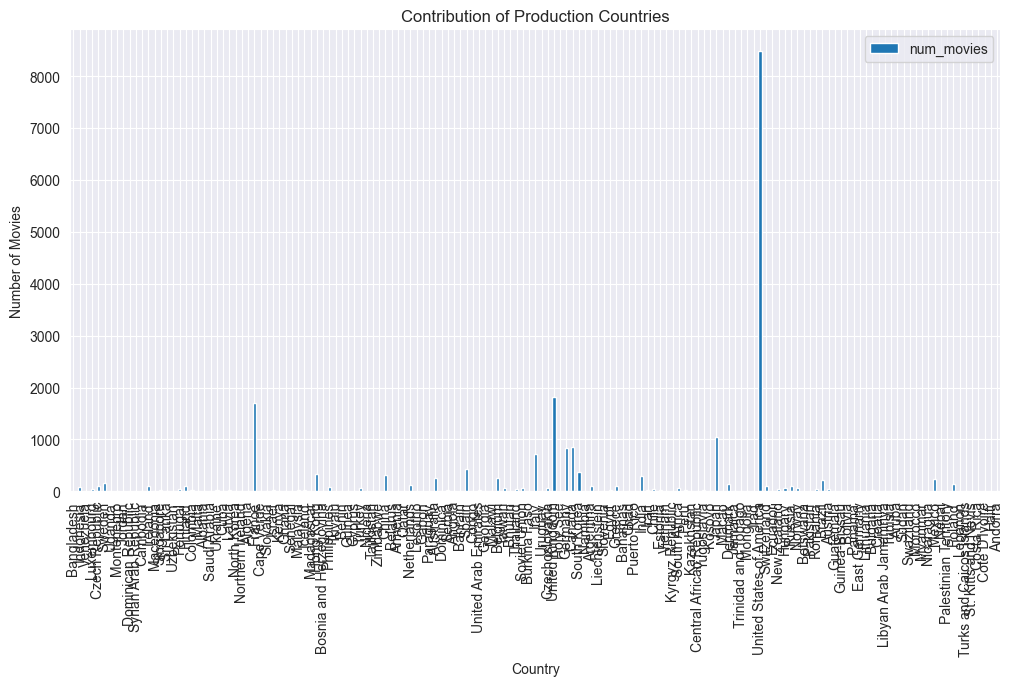

In [13]:
production_countries_contribution =query_db( """
SELECT ProductionCountries.name, COUNT(*) as num_movies
FROM MovieProductionCountries
JOIN ProductionCountries ON MovieProductionCountries.iso_3166_1 = ProductionCountries.iso_3166_1
GROUP BY ProductionCountries.name;
""", conn)

production_countries_contribution.plot(kind='bar', x='name', y='num_movies', figsize=(12, 6))
plt.title('Contribution of Production Countries')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


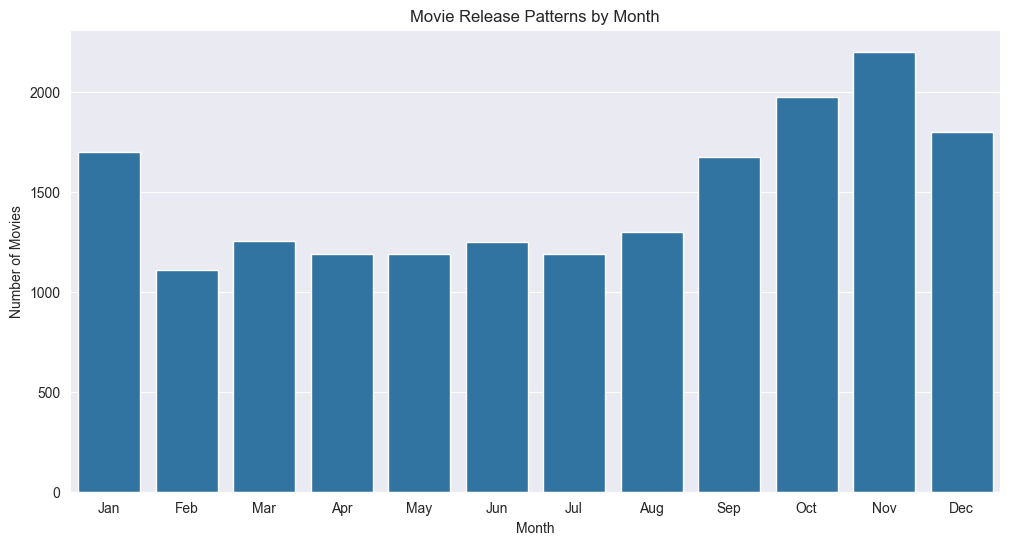

In [14]:
movie_release_pattern =query_db( """
SELECT EXTRACT(MONTH FROM release_date) as month, COUNT(*) as num_movies
FROM Movies
GROUP BY month
ORDER BY month;
""", conn)

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='num_movies', data=movie_release_pattern)
plt.title('Movie Release Patterns by Month')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


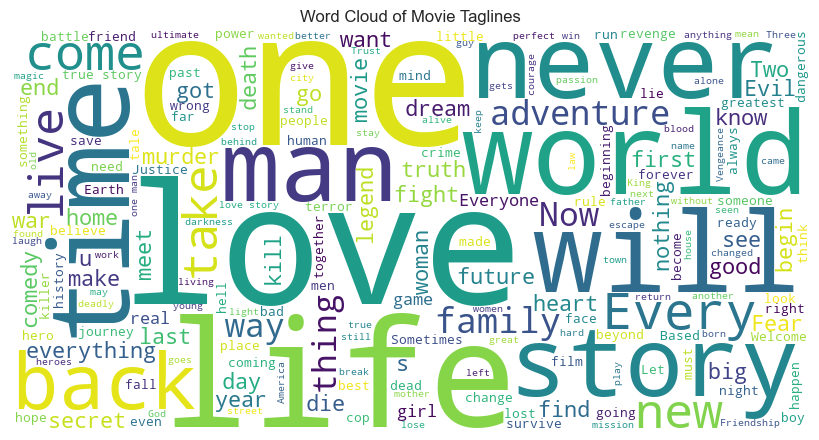

In [15]:
analysis_of_taglines =query_db( """
SELECT tagline
FROM Movies
WHERE tagline IS NOT NULL;
""", conn)


all_taglines = ' '.join(analysis_of_taglines['tagline'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_taglines)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud of Movie Taglines')
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


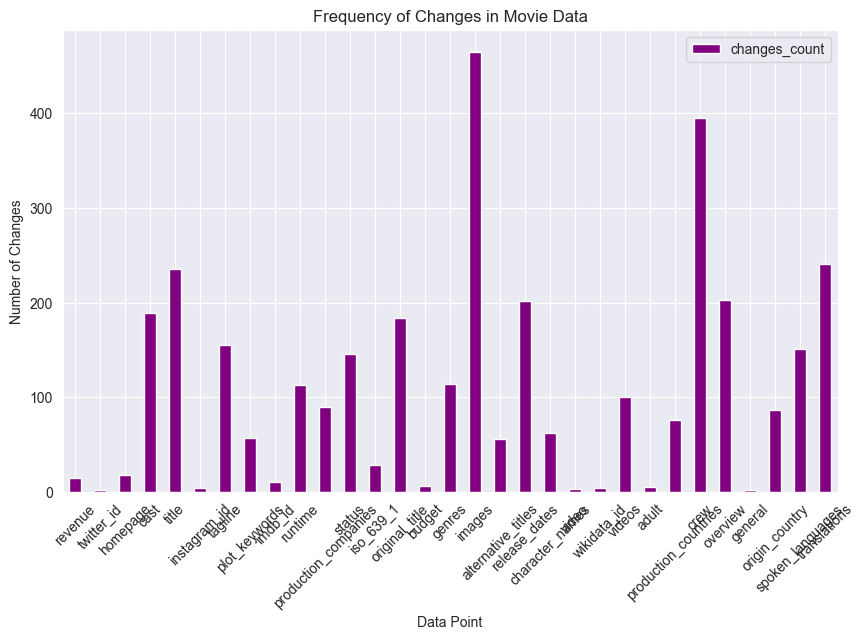

In [16]:
analysis_of_changelog =query_db( """
SELECT datapoint, COUNT(*) as changes_count
FROM Changes
GROUP BY datapoint;
""", conn)

analysis_of_changelog.plot(kind='bar', x='datapoint', y='changes_count', color='purple', figsize=(10, 6))
plt.title('Frequency of Changes in Movie Data')
plt.xlabel('Data Point')
plt.ylabel('Number of Changes')
plt.xticks(rotation=45)
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


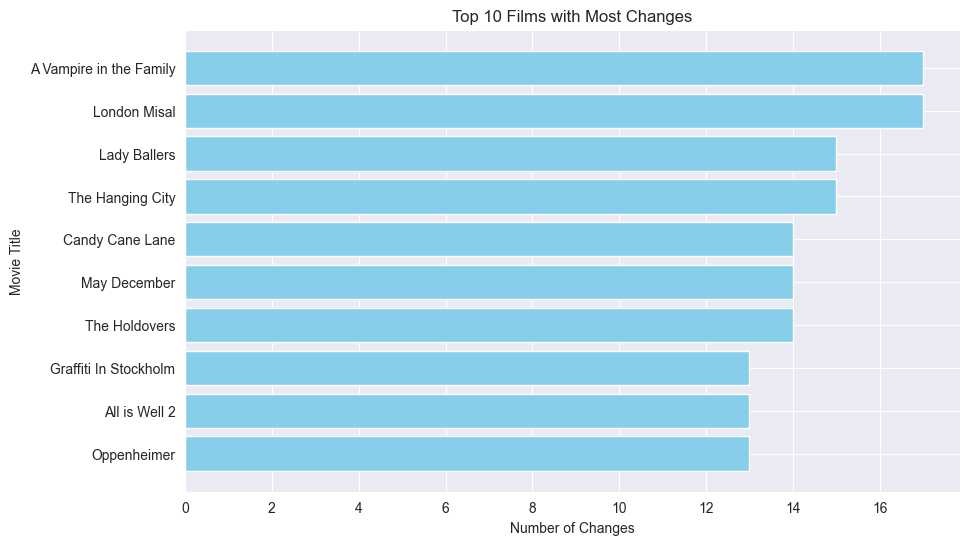

In [17]:
limit = 10
changes_per_movie =query_db( f"""
SELECT 
    Movies.title, 
    COUNT(Changes.movie_id) as change_count
FROM 
    Changes 
JOIN 
    Movies ON Changes.movie_id = Movies.id
GROUP BY 
    Movies.title
ORDER BY 
    change_count DESC
LIMIT {limit};
""", conn)

plt.figure(figsize=(10, 6))
plt.barh(changes_per_movie['title'], changes_per_movie['change_count'], color='skyblue')
plt.xlabel('Number of Changes')
plt.ylabel('Movie Title')
plt.title('Top 10 Films with Most Changes')
plt.gca().invert_yaxis()  
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_21880\2758919096.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql_query, conn)


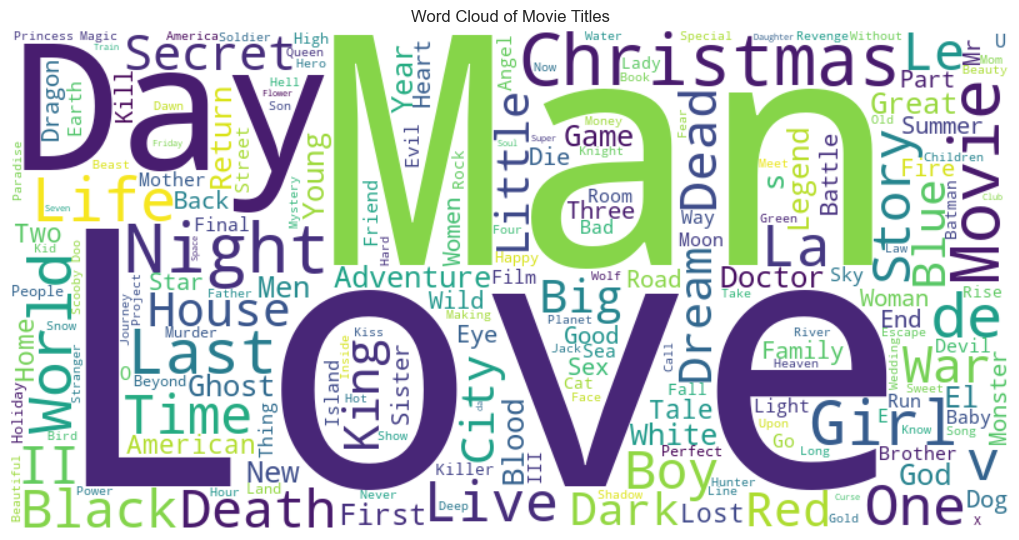

In [18]:
movie_titles_df =query_db( f"""
SELECT title
FROM Movies;
""", conn)

all_titles = ' '.join(movie_titles_df['title'].tolist())

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(all_titles)

plt.figure(figsize = (10, 5), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud of Movie Titles')
plt.show()

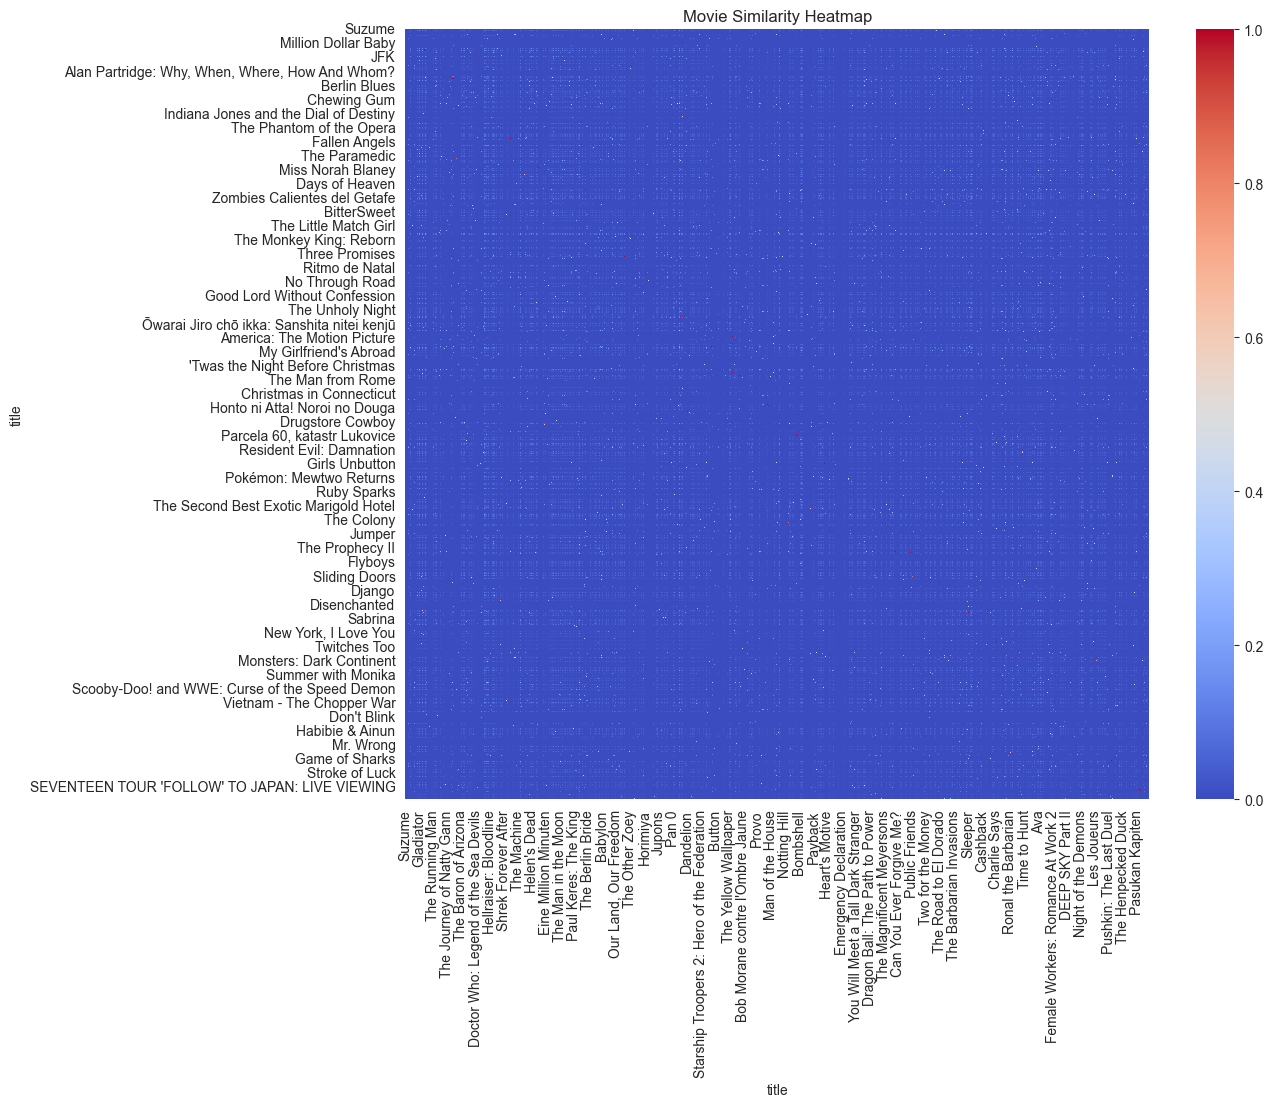

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Copy to not lose any movie titles for later
selected_similarity = movie_titles_df.copy()

selected_similarity['processed_overview'] = selected_similarity['title'].str.lower()


tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(selected_similarity['processed_overview'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=selected_similarity['title'], columns=selected_similarity['title'])

# heatmap
plt.figure(figsize=(100, 100))
sns.heatmap(cosine_sim_df, cmap='coolwarm')
plt.title('Movie Similarity Heatmap')
plt.savefig('movie_similarity_heatmap.png')
plt.show()

In [19]:
# Close the database connection
conn.close()